# ANN based Spectrum Sensing for CRN [PIMRC-2017]

---





---

Copyright: M. R. Vyas, Dhaval K. Patel and M. Lopez-Benitez

---







# 1. Importing and Initializing data

The list of packages that will be used in the study: -

1. numpy - For vectorized implementation
2. math - Inbuilt support for mathematical operations
3. time - measuring runtime
4. keras - for ANN model, training and testing

In [12]:
import numpy as np
import math
from scipy.stats import norm
import time
import pandas as pd
import statsmodels.api as sm
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.models import Sequential
from matplotlib import pyplot as plt
#import plotly.offline as py
#import plotly.graph_objs as go
#py.init_notebook_mode(connected=True)
%matplotlib inline

Data for all he four technologies are loaded into their respective vector names. They are all reshaped to convert them from Rank 1 arrays to proper Numpy vectors.

# 2.Retreiving data

Retreiving data from the files for all the four wireless technologies.

In [13]:
# Importing data from file (96.7 MHz)
FM = np.fromfile('96_7_20db', dtype=np.float32)

# Reshaping to convert to a proper NUMPY vector
FM = np.reshape(FM, (FM.shape[0], 1))

# Shape of FM signal vector
print("Size of FM: " + str(FM.shape))

# # Importing data from file (536.5 MHz)
# UHF = np.fromfile('536_5.dat', dtype=np.float32)

# # Reshaping to convert to a proper NUMPY vector
# UHF = np.reshape(UHF, (UHF.shape[0], 1))

# # Shape of UHF signal vector
# print("Size of UHF: " + str(UHF.shape))

# # Importing data from file (959 MHz)
# GSM = np.fromfile('959_45db', dtype=np.float32)

# # Reshaping to convert to a proper NUMPY vector
# GSM = np.reshape(GSM, (GSM.shape[0], 1))

# # Shape of GSM signal vector
# print("Size of GSM: " + str(GSM.shape))

# # Importing data from file (1840 MHz)
# DCS = np.fromfile('1840', dtype=np.float32)

# # Reshaping to convert to a proper NUMPY vector
# DCS = np.reshape(DCS, (DCS.shape[0], 1))

# # Shape of DCS signal vector
# print("Size of DCS: " + str(DCS.shape))

Size of FM: (1310720, 1)


# 3. Creating NUMPY equivalent for bandpower function

A MATLAB equivalent for bandpower function is created.

In [14]:
def bandpower(signal):
  return np.mean(signal ** 2)

In [15]:
bandpower(FM)

0.08954516

# 4. Creating NUMPY equivalent for AWGN (Additive White Gaussian Noise) function

First of all, the SNR (Signal-to-noise ratio) is converted from decibel scale to linear scale using the given formula:

$$\text{SNR}_{\text{linear}} = 10 ^ {\frac{\text{SNR}_{\text{dB}}}{10} }$$


The variance of standard the signal is adjusted using the formula given below:

$$\text{SNR}_{\text{linear}} = \frac{Power(signal)}{Var(noise)}\\
\implies \boxed{Power(signal) = Var(noise) \times \text{SNR}_{\text{linear}}}$$

In [16]:
def awgn(signal, desired_snr):
  
  # Converting the SNR from dB scale to linear scale
  snr_linear = math.pow(10, desired_snr / 10)
  
  # Standard normally distributed noise
  noise = np.random.randn(signal.shape[0], 1)
  
  # Using the boxed formula
  var_signal = bandpower(noise) * snr_linear
  
  # Normalizing the signal to have the given variance
  normalized_signal = math.sqrt(var_signal) * (signal / math.sqrt(bandpower(signal)))
  
  print("SNR = " + str(10 * math.log10(bandpower(normalized_signal) / bandpower(noise))))
  
  return normalized_signal + noise

# 5. Filtering the data

The datasets are filtered to remove any transient peaks. Values between $10^{-7}$ and $1$ are retained, others are discarded.

In [17]:
# Datasets are filtered to contain values between 10 ^ -7 and 1

FM = FM[np.logical_and(FM > math.pow(10, -7), FM < 1)]
FM = FM.reshape(FM.shape[0], 1)

# UHF = UHF[np.logical_and(UHF > math.pow(10, -7), UHF < 1)]
# UHF = UHF.reshape(UHF.shape[0], 1)

# GSM = GSM[np.logical_and(GSM > math.pow(10, -7), GSM < 1)]
# GSM = GSM.reshape(GSM.shape[0], 1)

# DCS = DCS[np.logical_and(DCS > math.pow(10, -7), DCS < 1)]
# DCS = DCS.reshape(DCS.shape[0], 1)

# Shape of FM signal vector
print("Size of FM: " + str(FM.shape))

# # Shape of UHF signal vector
# print("Size of UHF: " + str(UHF.shape))

# # Shape of GSM signal vector
# print("Size of GSM: " + str(GSM.shape))

# # Shape of DCS signal vector
# print("Size of DCS: " + str(DCS.shape))

# print(awgn(GSM[0:100000], 4).shape)

Size of FM: (1310720, 1)


# 6. Making the dataset ready

The following will create a dataset for the signal with a given SNR, number of samples and size of the samples in the sensing event. Dataset is constructed based on Energy values: -

Energy of the sensing event $E$ is given by,

$$E = \sum_{i = 1} ^{N} \big|y[n]\big|^{2} $$

In [18]:
def create_dataset(signal, desired_snr, samples, sample_size):
  
  # Creating the signal with desired SNR
  snr_signal = awgn(signal[0:samples * sample_size], desired_snr)
  
  # Allocating zeros to the dataset
  X = np.zeros((samples, 1))
  
  for i in range(0, samples):
    
    # Extracting the sample based on sample size
    sampled_signal = snr_signal[i * sample_size : (i + 1) * sample_size]
    
    # Sorting the sampled signal
    sampled_signal = np.sort(sampled_signal, axis=0)
    
    # Energy detection
    E = np.sum(sampled_signal ** 2)
    
    # Assigning values to the dataset
    X[i][0] = E
  
  return X

In [19]:
a = time.time()
print(create_dataset(FM[50000:], 4, 15000, 100).shape)
b = time.time()

# Printing the time taken for execution
print(b - a)

SNR = 3.9999998731018307
(15000, 1)
0.22601032257080078


Making the dataset for all the SNRs in the range -20 till 4 with step size of 2. The following function will take a range of SNRs as input and will output the dataset. Other inputs are the sample size, the signal, and, the number of samples per SNR.

In [20]:
def final_dataset(signal, snr_range, samples_per_snr, sample_size):
  X = {}
  
  for snr in snr_range:
    # Creating dataset for the given SNR
    X_snr = create_dataset(signal, snr, samples_per_snr, sample_size)
    
    # Indexing within the final dataset matrix X
    X[snr] = X_snr
  
  return X

In [21]:
a = time.time()

# FM
X_FM = {**final_dataset(FM[100000:], range(-20, -4, 2), 5000, 100), **final_dataset(FM[100000:], range(-4, 6, 2), 12000, 100)}
X_test_FM = final_dataset(FM[300000:], range(-20, 6, 2), 5129, 100)
b = time.time()

# Printing the time taken for execution
print("Time taken :- " + str(b - a))

SNR = -20.000001332349203
SNR = -18.000001291873343
SNR = -16.000000557150816
SNR = -14.00000075537632
SNR = -12.00000010897487
SNR = -10.000000796315387
SNR = -8.000001484905274
SNR = -6.0000011995130755
SNR = -4.0000000662436275
SNR = -1.9999996884631805
SNR = -1.3916347305518976e-06
SNR = 1.9999995417690941
SNR = 4.000000605666218
SNR = -19.9999990211507
SNR = -17.999998870093414
SNR = -15.999999900916187
SNR = -13.999999391140284
SNR = -11.999999565297996
SNR = -9.999999492819464
SNR = -7.999999443160936
SNR = -5.999998358182759
SNR = -3.9999986129245113
SNR = -1.9999983958030907
SNR = 9.651244183959063e-07
SNR = 2.0000007557536437
SNR = 4.000000940338355
Time taken :- 2.735877275466919


# 7. Generating White noise sequence

White noise of variance 1 is generated and is labelled as 0.

In [22]:
def create_noise_sequence(samples, sample_size):
  
  # Creating white noise sequence of variance 1
  noise = np.random.randn(samples * sample_size, 1)
  
  # Allocating zeros to the dataset
  X = np.zeros((samples, 1))
  
  for i in range(0, samples):
    
    # Extracting the sample based on sample size
    sampled_signal = noise[i * sample_size : (i + 1) * sample_size]
    
    # Sorting the sampled signal
    sampled_signal = np.sort(sampled_signal, axis=0)
    
    # Energy detection
    E = np.sum(sampled_signal ** 2)
    
    # Assigning values to the dataset
    X[i][0] = E
  
  return X

In [23]:
a = time.time()
X_noise = create_noise_sequence(100000, 100)
b = time.time()

print("Time taken = " + str(b - a))

print(X_noise.shape)

Time taken = 1.5676159858703613
(100000, 1)


# 8. Autocorrelation Function

The autocorrelation function for energy values is plotted for the wireless technology FM.

In [24]:
# for snr in range(-20, 6, 2):
#   plt.figure(figsize=(15,7))
#   ax = plt.subplot(211)

#   x = X_UHF[snr][:, 0]
#   x = x.reshape(x.shape[0], 1)

#   sm.graphics.tsa.plot_acf(x, lags=50, ax=ax)
#   plt.title("Autocorrelation in energy values at SNR = " + str(snr))
#   # ax = plt.subplot(212)
#   # sm.graphics.tsa.plot_pacf(x, lags=50, ax=ax)
#   # plt.title("Partial Autocorrelation in energy values at SNR = " + str(snr))
#   # plt.tight_layout()
#   plt.show()

# 9. DataSet with Lookback for ANN

The output of an Recurrent Neural network depends on the previous training examples. Here, we will define a lookback to determine how many previous examples should the RNN look into to predict the output.

In [25]:
# Function for Chaning the dataset for look back
def create_look_back(X, look_back=1):
  
  # Look back dataset is initialized to be empty
  look_back_X = []
  
  for i in range(len(X) - look_back + 1):
    # Extracting an example from the dataset
    a = X[i:(i + look_back), :]
    
    a = a.flatten() # (For flattening)
    
    # Appending to the dataset
    look_back_X.append(a)
  
  look_back_Y = []
    
  # Returning in numpy's array format
  return np.array(look_back_X)

The following function will insert look backs into our dataset for all the SNRs.

In [26]:
def dataset_look_back(X_tech, snr_range, look_back):
  X_tech_lb = {}
  
  # Look backs for all SNRs
  for snr in snr_range:
    X_tech_lb[snr] = create_look_back(X_tech[snr], look_back)
  
  return X_tech_lb

In [27]:
look_back = 2

X_FM_lb = dataset_look_back(X_FM, range(-20, 6, 2), look_back)
print(X_FM_lb[-20].shape)

X_noise_lb = create_look_back(X_noise, look_back)
print(X_noise_lb.shape)

X = X_FM_lb[-20]
y = []

for snr in range(-18, 6, 2):
  X = np.concatenate((X, X_FM_lb[snr]), axis=0)

y = np.ones((X.shape[0], 1))
 
print(X.shape)
print(X_noise_lb.shape)
X = np.concatenate((X, X_noise_lb), axis=0)

y = np.concatenate((y, np.zeros((X_noise_lb.shape[0], 1))))
#Xtrain, Xtest, Ytrain and Ytest (in matlab as .mat files)

(4999, 2)
(99999, 2)
(99987, 2)
(99999, 2)


# 10. Creating the ANN model

Defining a sequential model with two stacked LSTM layers with a single Dense output layer

In [28]:
seed = 9
np.random.seed(seed)
#Loading the data, here It's a feature data, which contains 4 features as mentioned in papers 

#ANN Model 
# create model
model = Sequential() # This means it's sequential model, which is from one direction to another in sequence 
model.add(Dense(7, input_dim=2, kernel_initializer='uniform', activation='relu'))#First layer with 20 nodes and as we have 4 features so input_dim would be 4, relu suits well for binary classification so I have used it 
#model.add(Dense(10, init='uniform', activation='relu')) #You can add as many hidden layer you want, but with time complexity 
#model.add(Dense(5,init='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid')) #Output layer

# Compile model
#This function you have to explore in case you want to do the mathematic analysis
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 11. Training the ANN model

In [29]:
# Fit the model
#Training and batch size
model.fit(X, y, epochs=40, batch_size=150,  verbose=2)

#Evaluate the model
scores = model.evaluate(X, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


Epoch 1/40
1334/1334 - 4s - loss: 0.5709 - accuracy: 0.6609
Epoch 2/40
1334/1334 - 2s - loss: 0.4445 - accuracy: 0.8006
Epoch 3/40
1334/1334 - 2s - loss: 0.4240 - accuracy: 0.8022
Epoch 4/40
1334/1334 - 2s - loss: 0.4213 - accuracy: 0.8014
Epoch 5/40
1334/1334 - 2s - loss: 0.4204 - accuracy: 0.8011
Epoch 6/40
1334/1334 - 2s - loss: 0.4175 - accuracy: 0.8031
Epoch 7/40
1334/1334 - 2s - loss: 0.4175 - accuracy: 0.8023
Epoch 8/40
1334/1334 - 2s - loss: 0.4167 - accuracy: 0.8030
Epoch 9/40
1334/1334 - 2s - loss: 0.4157 - accuracy: 0.8033
Epoch 10/40
1334/1334 - 2s - loss: 0.4164 - accuracy: 0.8031
Epoch 11/40
1334/1334 - 2s - loss: 0.4142 - accuracy: 0.8041
Epoch 12/40
1334/1334 - 2s - loss: 0.4139 - accuracy: 0.8041
Epoch 13/40
1334/1334 - 2s - loss: 0.4131 - accuracy: 0.8040
Epoch 14/40
1334/1334 - 2s - loss: 0.4135 - accuracy: 0.8042
Epoch 15/40
1334/1334 - 2s - loss: 0.4127 - accuracy: 0.8043
Epoch 16/40
1334/1334 - 2s - loss: 0.4127 - accuracy: 0.8047
Epoch 17/40
1334/1334 - 2s - loss

157/157 [==============================] - 0s 1ms/step - loss: 1.3051 - accuracy: 0.0552
At SNR = -20
accuracy: 5.52%
157/157 [==============================] - 0s 1ms/step - loss: 1.2859 - accuracy: 0.0660
At SNR = -18
accuracy: 6.60%
157/157 [==============================] - 0s 1ms/step - loss: 1.2632 - accuracy: 0.0722
At SNR = -16
accuracy: 7.22%
157/157 [==============================] - 0s 1ms/step - loss: 1.1986 - accuracy: 0.1066
At SNR = -14
accuracy: 10.66%
157/157 [==============================] - 0s 2ms/step - loss: 1.1259 - accuracy: 0.1530
At SNR = -12
accuracy: 15.30%
157/157 [==============================] - 0s 1ms/step - loss: 0.9910 - accuracy: 0.2505
At SNR = -10
accuracy: 25.05%
157/157 [==============================] - 0s 1ms/step - loss: 0.7768 - accuracy: 0.4351
At SNR = -8
accuracy: 43.51%
157/157 [==============================] - 0s 1ms/step - loss: 0.4855 - accuracy: 0.6911
At SNR = -6
accuracy: 69.11%
375/375 [==============================] - 1s 1ms/ste

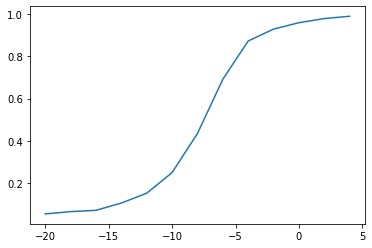

In [30]:
#Plot of Pd v/s SNR
pd_FM = {}

for snr in range(-20, 6, 2):
  y_snr = np.ones((X_FM_lb[snr].shape[0], 1))
  scores = model.evaluate(X_FM_lb[snr], y_snr)
  print("At SNR = " + str(snr) + "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  pd_FM[snr] = scores[1]
  
plt.plot(range(-20, 6, 2), list(pd_FM.values()))
